In [1]:
%matplotlib inline

In [2]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from nilearn.input_data import NiftiMasker
import seaborn as sns

In [3]:
data_dir = '/home/julia/data/gradients/'

In [4]:
mask_img = nb.load(data_dir + 'allen_atlas/cortex_mask_tight_200um.nii.gz')
mask = mask_img.get_data()
aff = mask_img.affine
hdr = mask_img.header

In [5]:
df = pd.read_csv(data_dir + "allen_atlas/gene_expression/gene_list_full.csv")
df = df[df['acronym']!="FALSE"]
df = df[np.isnan(df['entrez'])==False]
df = df.reset_index(drop=True)

### Make a mask that has data in >50% of gene maps

In [6]:
ids = list(df['id'])
gene_mask = np.zeros(mask.shape)
n_maps = 0
miss = []
for n in range(len(ids)):
    try:
        # load and save as nifti
        gene = np.swapaxes(io.imread(data_dir + 'allen_atlas/gene_expression/energy/%s/energy.mhd'% ids[n],
                                      plugin='simpleitk'), 
                            0,2)[:-1,:-1,:-1]
        nb.save(nb.Nifti1Image(gene, aff, hdr), data_dir + 
                                                'allen_atlas/gene_expression/energy/%s/energy.nii.gz'% ids[n])
        
        # count how many maps have data in a given voxel
        gene_mask[np.where(gene >= 0)] += 1
        n_maps += 1

    except RuntimeError:
        miss.append(ids[n])
        pass

gene_mask[mask==0] = 0

In [12]:
# Drop entries that don't have a map from dataframe
for m in miss:
    df = df.drop(df[df['id']==m].index.values[0])
df = df.reset_index(drop=True)

In [14]:
# Create a mask that is covered at least by half of the expression data
gene_mask_thr = np.zeros(mask.shape)
gene_mask_thr[gene_mask >= (n_maps/2)] = 1
nb.save(nb.Nifti1Image(gene_mask_thr, aff, hdr), data_dir+'allen_atlas/gene_expression/gene_mask.nii.gz')

### Combine energy for experiments probing the same gene (entrez)

In [15]:
# Smooth while loading and compressing
masker = NiftiMasker(mask_img=nb.Nifti1Image(gene_mask_thr, aff, hdr), 
                     standardize=False, smoothing_fwhm=0.45)

In [16]:
entrez = np.unique(df['entrez'])
energy = np.zeros((np.where(gene_mask_thr==1)[0].shape[0], entrez.shape[0]))

for e in range(entrez.shape[0]):
    # find all probes for that gene
    probes = list(df[df['entrez']==entrez[e]]['id'])
    
    gene = np.zeros(mask.shape)
    for p in probes:
        # load nifti
        gene += nb.load(data_dir+'allen_atlas/gene_expression/energy/%s/energy.nii.gz'% p).get_data()
    gene = gene / len(probes)
    
    # smooth and add to gene matrix            
    energy[:,e] = masker.fit_transform(nb.Nifti1Image(gene, aff, hdr))

In [17]:
np.save(data_dir+'allen_atlas/gene_expression/energy.npy', energy)

In [19]:
df_energy = pd.DataFrame(index=entrez, data=energy.T)
df_energy.to_csv(data_dir + 'allen_atlas/gene_expression/energy.csv')

### Normalize gene expression data using sigmoid function and standard rescaling

In [20]:
energy = np.load(data_dir + 'allen_atlas/gene_expression/energy.npy')

In [21]:
def sigmoid(energy):
    X = (energy - np.mean(energy)) / np.std(energy)
    sig = 1 / (1 + np.exp(-X))
    return sig

In [22]:
sigmoid_energy = np.zeros_like(energy)
for e in range(energy.shape[1]):
    sigmoid_energy[:,e] = sigmoid(energy[:,e])

In [29]:
# Standardizing the features
standard_energy = StandardScaler().fit_transform(sigmoid_energy)

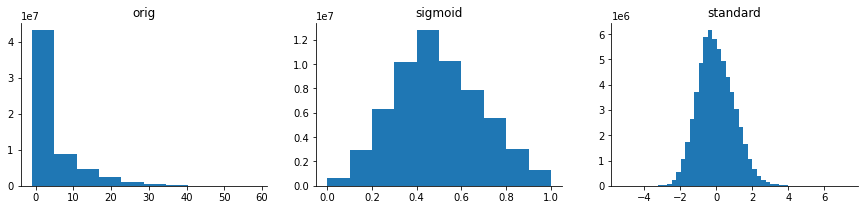

In [31]:
fig = plt.figure(figsize=(15,3))
fig.add_subplot(1,3,1)
plt.hist(energy.flatten());
plt.title('orig')
fig.add_subplot(1,3,2)
plt.hist(sigmoid_energy.flatten());
plt.title('sigmoid')
fig.add_subplot(1,3,3)
plt.hist(standard_energy.flatten(), bins=50);
plt.title('standard')
sns.despine()

### Run PCA

In [32]:
pca = PCA(n_components=500)
pcs = pca.fit_transform(standard_energy)

In [33]:
comp05 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.5)[0][0]
comp09 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]

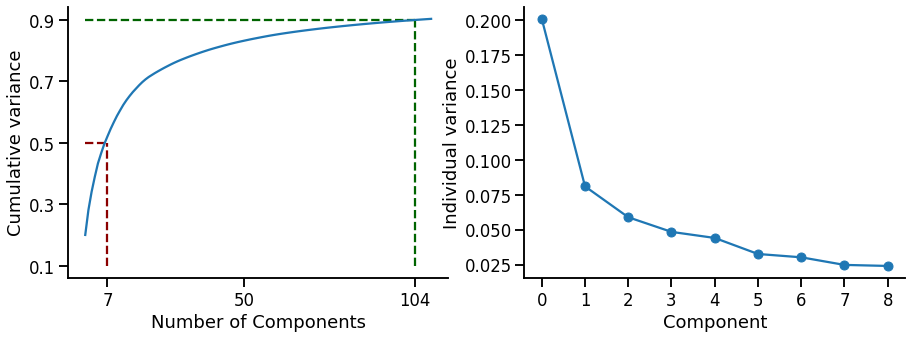

In [34]:
#Plotting the Cumulative Summation of the Explained Variance
sns.set_context("talk")
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:110])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance') 
plt.xticks([comp05, 50, comp09])
plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.hlines(0.9, 0, comp09, color='darkgreen', linestyle="--")
plt.vlines(comp09, 0.1, 0.9, color='darkgreen', linestyle="--")
plt.hlines(0.5, 0, comp05, color='darkred', linestyle="--")
plt.vlines(comp05, 0.1, 0.5, color='darkred', linestyle="--")
sns.despine()

fig.add_subplot(122)
plt.plot(pca.explained_variance_ratio_[:9], 'o', linestyle="-")
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.xlabel('Component')
plt.ylabel('Individual variance') 
sns.despine()

In [35]:
np.save(data_dir + 'results/gene_expression/pca_components.npy', pcs)

### Save first six PCAs as images

In [40]:
pca_img = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 6))
for p in range(6):
    pca_img[:,:,:,p] = masker.inverse_transform(pcs[:,p]).get_data()
nb.save(nb.Nifti1Image(pca_img, aff, hdr), data_dir + 'results/gene_expression/pca_img.nii.gz')

### Plot

In [41]:
x=30
y=12
z=20

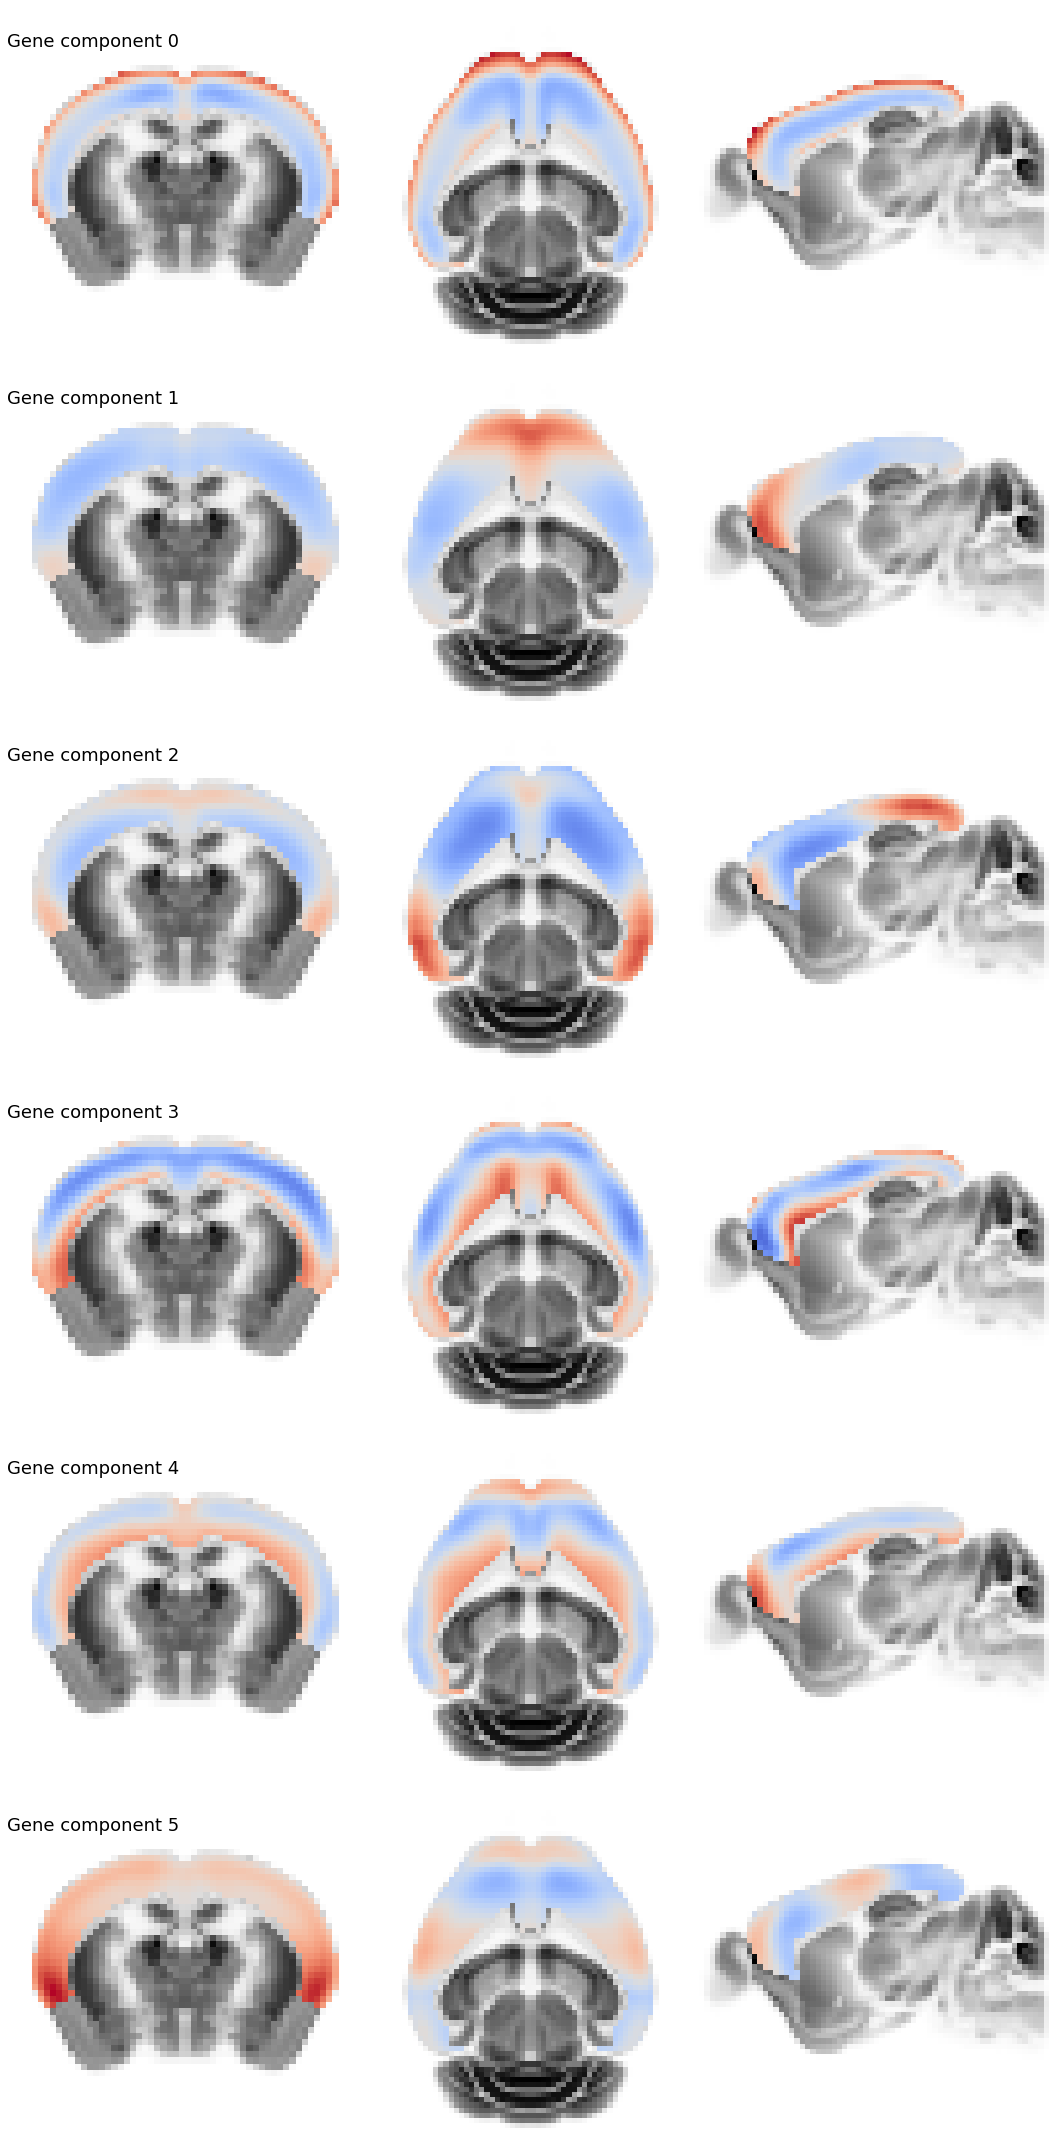

In [42]:
template = nb.load(data_dir+'allen_atlas/template_200um.nii.gz').get_data()
gradients = nb.load(data_dir + 'results/gene_expression/pca_img.nii.gz').get_data()
fig = plt.figure(figsize=(15,30))
for g in range(6):
    
    gradient = gradients[:,:,:,g]
    gradient[gene_mask_thr==0] = np.nan
    vmax = np.max([np.abs(np.nanmin(gradient)), np.abs(np.nanmax(gradient))])
    vmin = -vmax
    
    template_img = [template[x,:,:], template[:,y,:], template[:,:,z].T]
    gradient_img = [gradient[x,:,:], gradient[:,y,:], gradient[:,:,z].T]
    
    for i in range(3):
        
        fig.add_subplot(6,3,(g*3+(i+1)))
        plt.imshow(template_img[i],  cmap='Greys', aspect='equal');
        plt.imshow(gradient_img[i],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
        if i == 0:
            plt.title('Gene component %s' %g, loc='left')
        plt.axis('off');

plt.tight_layout()

### Calculate Loading of individual Genes to PCs

In [65]:
loading_matrix = (pca.components_.T * np.sqrt(pca.explained_variance_))[:,:6]

In [91]:
loading_df = pd.DataFrame(columns=['Entrez_ID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], 
                          data=np.hstack((np.array(entrez[:,np.newaxis], dtype=np.int16), loading_matrix)))

In [93]:
loading_df.to_csv(data_dir + 'results/gene_expression/loading.csv')